In [1]:
!pip -q install kagglehub tensorflow tensorflow-addons opencv-python-headless matplotlib scikit-learn pillow


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub
from pathlib import Path
import random

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


/Users/ahmed/Documents/CSULB/Machine Vision - CECS 553/Project/Pix2CT/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print("\n" + "="*80)
print("HARDWARE CONFIGURATION")
print("="*80)

# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✓ GPU Available: {len(gpus)} GPU(s) detected")
    # Configure GPU memory growth (prevents TensorFlow from allocating all GPU memory)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Memory growth setting error: {e}")

    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
else:
    print("\n No GPU detected - using CPU")

print("="*80)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


HARDWARE CONFIGURATION

 No GPU detected - using CPU


In [4]:
path = kagglehub.dataset_download("ozguraslank/brain-stroke-ct-dataset")
print("Path to dataset files:", path)

# Explore dataset structure
dataset_path = Path(path)
print("\nDataset directories found:")
for item in dataset_path.rglob("*"):
    if item.is_dir():
        # Count image files in this directory
        image_count = len(list(item.glob("*.jpg"))) + len(list(item.glob("*.png"))) + \
                     len(list(item.glob("*.jpeg"))) + len(list(item.glob("*.bmp")))
        if image_count > 0:
            print(f"📁 {item.relative_to(dataset_path)} ({image_count} images)")

Using Colab cache for faster access to the 'brain-stroke-ct-dataset' dataset.
Path to dataset files: /kaggle/input/brain-stroke-ct-dataset

Dataset directories found:
📁 Brain_Stroke_CT_Dataset/Ischemia/OVERLAY (1130 images)
📁 Brain_Stroke_CT_Dataset/Ischemia/PNG (1130 images)
📁 Brain_Stroke_CT_Dataset/Bleeding/OVERLAY (1093 images)
📁 Brain_Stroke_CT_Dataset/Bleeding/PNG (1093 images)
📁 Brain_Stroke_CT_Dataset/Normal/PNG (4427 images)
📁 Brain_Stroke_CT_Dataset/External_Test/OVERLAY (200 images)
📁 Brain_Stroke_CT_Dataset/External_Test/MASKS (200 images)
📁 Brain_Stroke_CT_Dataset/External_Test/PNG (200 images)


In [5]:
IMG_SIZE = 256
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

def load_images_from_folder(folder_path, label):
    """Load images from a folder with given label - supports all image formats"""
    images = []
    labels = []

    # Check for various image extensions
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tif', '*.tiff']

    for ext in extensions:
        for img_path in Path(folder_path).rglob(ext):  # Use rglob for recursive search
            try:
                img = cv2.imread(str(img_path))
                if img is not None:
                    # Convert to RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    # Resize
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    images.append(img)
                    labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    return images, labels

# Load data for all three categories
all_images = []
all_labels = []
label_map = {'Normal': 0, 'Bleeding': 1, 'Ischemia': 2}

print("\n" + "="*80)
print("LOADING IMAGES")
print("="*80)

# Try different possible directory structures
for category in ['Normal', 'Bleeding', 'Ischemia']:
    found = False

    # Search for directories containing the category name (case-insensitive)
    for item in dataset_path.rglob("*"):
        if item.is_dir() and category.lower() in item.name.lower():
            print(f"\nLoading {category} images from: {item}")
            images, labels = load_images_from_folder(item, label_map[category])

            if len(images) > 0:
                all_images.extend(images)
                all_labels.extend(labels)
                print(f"✓ Loaded {len(images)} images for {category}")
                found = True
                break  # Found the category, move to next

    if not found:
        print(f"✗ No images found for {category}")

# Convert to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

print("\n" + "="*80)
print("LOADING SUMMARY")
print("="*80)
print(f"Total images loaded: {len(all_images)}")
if len(all_images) > 0:
    print(f"Image shape: {all_images.shape}")
    print(f"Label distribution:")
    for label_name, label_idx in label_map.items():
        count = np.sum(all_labels == label_idx)
        print(f"  {label_name}: {count} images")
else:
    print("WARNING: No images loaded!")



LOADING IMAGES

Loading Normal images from: /kaggle/input/brain-stroke-ct-dataset/Brain_Stroke_CT_Dataset/Normal
✓ Loaded 4427 images for Normal

Loading Bleeding images from: /kaggle/input/brain-stroke-ct-dataset/Brain_Stroke_CT_Dataset/Bleeding
✓ Loaded 2186 images for Bleeding

Loading Ischemia images from: /kaggle/input/brain-stroke-ct-dataset/Brain_Stroke_CT_Dataset/Ischemia
✓ Loaded 2260 images for Ischemia

LOADING SUMMARY
Total images loaded: 8873
Image shape: (8873, 256, 256, 3)
Label distribution:
  Normal: 4427 images
  Bleeding: 2186 images
  Ischemia: 2260 images


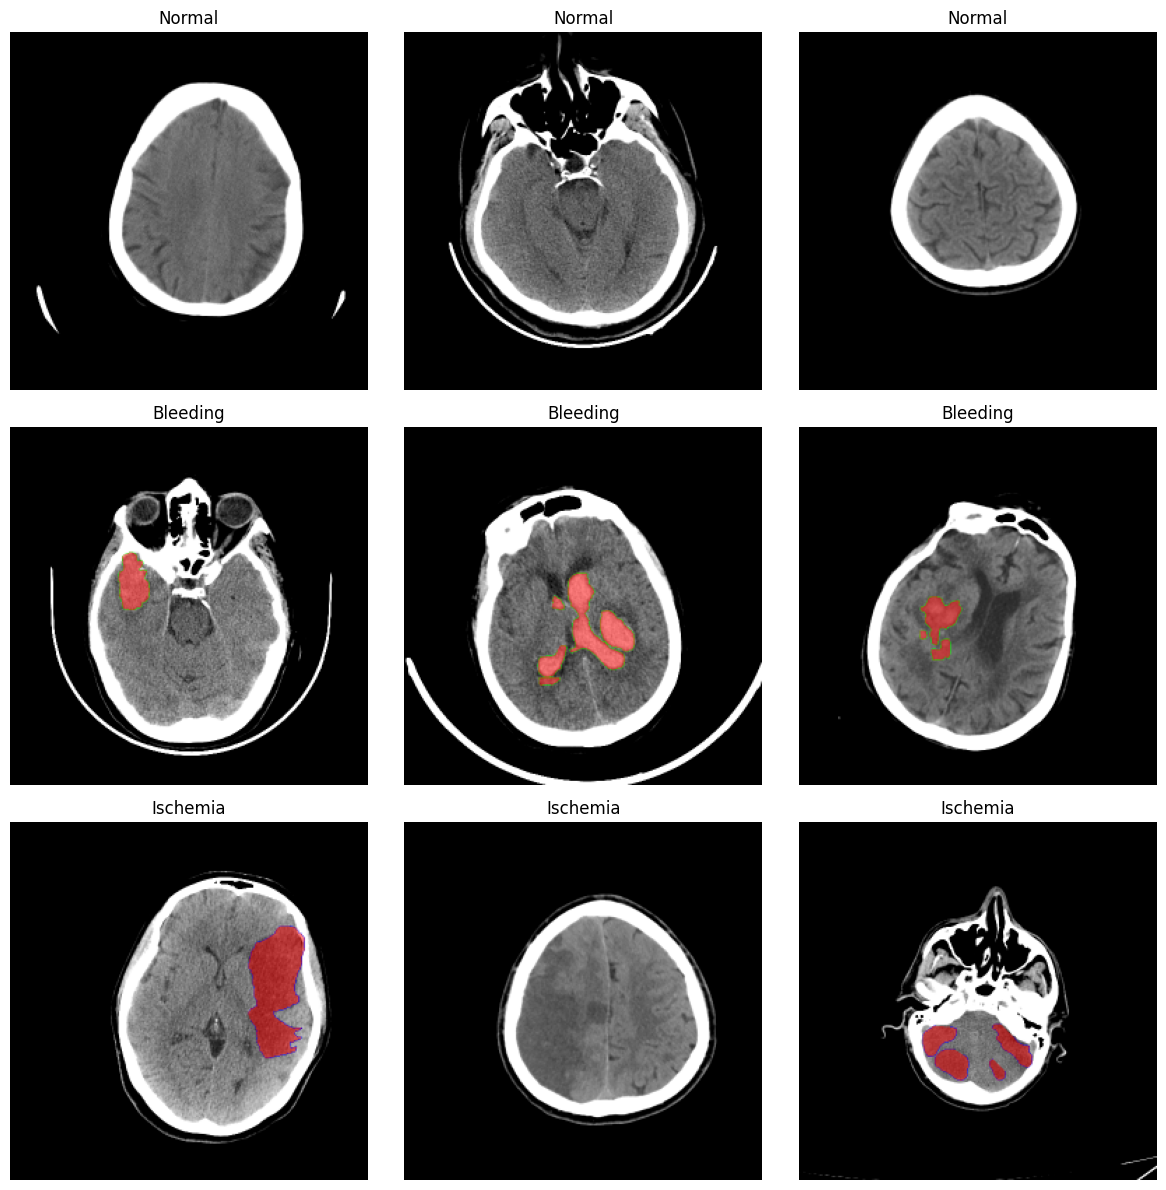

In [6]:
def visualize_samples(images, labels, num_samples=9):
    """Visualize random samples from dataset"""
    label_names = {0: 'Normal', 1: 'Bleeding', 2: 'Ischemia'}

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()

    class_indices = {0: [], 1: [], 2: []}
    for idx, label in enumerate(labels):
        class_indices[label].append(idx)

    # Select 3 samples from each class
    indices = []
    for class_id in [0, 1, 2]:
        indices.extend(random.sample(class_indices[class_id], 3))

    for idx, ax_idx in enumerate(indices):
        axes[idx].imshow(images[ax_idx])
        axes[idx].set_title(f"{label_names[labels[ax_idx]]}")
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(all_images, all_labels)

In [7]:
def downsample(filters, size, apply_batchnorm=True):
    """Downsampling block for encoder"""
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(layers.BatchNormalization())

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    """Upsampling block for decoder"""
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def Generator():
    """Pix2Pix U-Net Generator"""
    inputs = layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])

    # Encoder (downsampling)
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    # Decoder (upsampling)
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [8]:
def Discriminator():
    """PatchGAN discriminator"""
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3], name='input_image')
    tar = layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3], name='target_image')

    x = layers.concatenate([inp, tar])

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return keras.Model(inputs=[inp, tar], outputs=last)

In [9]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    """Generator loss = adversarial loss + L1 loss (fixed for mixed precision)"""
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    gen_output_f32 = tf.cast(gen_output, tf.float32)
    target_f32 = tf.cast(target, tf.float32)

    # L1 loss
    l1_loss = tf.reduce_mean(tf.abs(target_f32 - gen_output_f32))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    """Discriminator loss"""
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [10]:
generator = Generator()
discriminator = Discriminator()

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

print("Generator Summary:")
generator.summary()

print("\nDiscriminator Summary:")
discriminator.summary()

Generator Summary:


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)


Discriminator Summary:


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 128, 128,  │      6,144 │ concatenate_7[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 64, 64,    │    131,584 │ sequential_15[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 32, 32,    │    525,312 │ sequential_16[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 34, 34,    │          0 │ sequential_17[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 31, 31,    │  2,097,152 │ zero_padding2d[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_11      │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 33, 33,    │          0 │ leaky_re_lu_11[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [16]:
checkpoint_dir = './pix2pix_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

checkpoint_manager = tf.train.CheckpointManager(
    checkpoint, checkpoint_dir, max_to_keep=3
)

print("\n" + "="*80)
print("CHECKPOINT CONFIGURATION")
print("="*80)
print(f"Checkpoint directory: {checkpoint_dir}")
print(f"Latest checkpoint: {checkpoint_manager.latest_checkpoint}")

# Load latest checkpoint if it exists
if checkpoint_manager.latest_checkpoint:
    checkpoint.restore(checkpoint_manager.latest_checkpoint)
    print("Restored from latest checkpoint!")
else:
    print("No checkpoint found")
print("="*80)


CHECKPOINT CONFIGURATION
Checkpoint directory: ./pix2pix_checkpoints
Latest checkpoint: None
No checkpoint found


In [17]:
ACCUMULATION_STEPS = 4

@tf.function
def train_step(input_image, target_image):
    """Single training step for Pix2Pix (memory optimized)"""
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target_image], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target_image)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                           generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                           generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                               discriminator.trainable_variables))

    return gen_total_loss, disc_loss

def prepare_pix2pix_data(images):
    """
    Prepare data for Pix2Pix training
    Input: full CT scan, Target: downsampled then upsampled CT scan (simulating skipped slices)
    """
    input_images = []
    target_images = []

    for img in images:
        # Normalize to [-1, 1] for Pix2Pix
        target = (img.astype(np.float32) / 127.5) - 1.0

        # Simulate skipped slices by downsampling and upsampling
        h, w = img.shape[:2]
        downsampled = cv2.resize(img, (w//4, h//4), interpolation=cv2.INTER_LINEAR)
        input_img = cv2.resize(downsampled, (w, h), interpolation=cv2.INTER_LINEAR)
        input_img = (input_img.astype(np.float32) / 127.5) - 1.0

        input_images.append(input_img)
        target_images.append(target)

    return np.array(input_images), np.array(target_images)

In [ ]:
tf.keras.backend.clear_session()

print("\n" + "="*80)
print("PIX2PIX DATA PREPARATION")
print("="*80)

# Use smaller batch size for memory efficiency
BATCH_SIZE_PIX2PIX = 16
EPOCHS_PIX2PIX = 50

def prepare_pix2pix_data_generator(images, batch_size=BATCH_SIZE_PIX2PIX):
    """
    Generator for Pix2Pix training
    Prepares data on-the-fly instead of loading all at once
    """
    num_samples = len(images)

    while True:
        # Shuffle indices
        indices = np.random.permutation(num_samples)

        for start_idx in range(0, num_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]

            input_batch = []
            target_batch = []

            for idx in batch_indices:
                img = images[idx]

                # Normalize to [-1, 1] for Pix2Pix
                target = (img.astype(np.float32) / 127.5) - 1.0

                # Simulate skipped slices by downsampling and upsampling
                h, w = img.shape[:2]
                downsampled = cv2.resize(img, (w//4, h//4), interpolation=cv2.INTER_LINEAR)
                input_img = cv2.resize(downsampled, (w, h), interpolation=cv2.INTER_LINEAR)
                input_img = (input_img.astype(np.float32) / 127.5) - 1.0

                input_batch.append(input_img)
                target_batch.append(target)

            yield np.array(input_batch), np.array(target_batch)

# Split data BEFORE converting (save memory)
train_images, val_images = train_test_split(
    all_images, test_size=0.2, random_state=42
)

print(f"Training samples: {len(train_images)}")
print(f"Validation samples: {len(val_images)}")
print("\nPreparing validation data...")
val_inputs = []
val_targets = []
for img in val_images[:20]:  # Only 20 samples for validation
    target = (img.astype(np.float32) / 127.5) - 1.0
    h, w = img.shape[:2]
    downsampled = cv2.resize(img, (w//4, h//4), interpolation=cv2.INTER_LINEAR)
    input_img = cv2.resize(downsampled, (w, h), interpolation=cv2.INTER_LINEAR)
    input_img = (input_img.astype(np.float32) / 127.5) - 1.0
    val_inputs.append(input_img)
    val_targets.append(target)

val_inputs = np.array(val_inputs)
val_targets = np.array(val_targets)

print(f"Validation data prepared: {len(val_inputs)} samples")


PIX2PIX DATA PREPARATION (Memory-Efficient)
Training samples: 7098
Validation samples: 1775

Preparing validation data...
Validation data prepared: 20 samples


In [19]:
def train_pix2pix(epochs, save_every=10):
    """Train Pix2Pix model"""

    steps_per_epoch = len(train_images) // BATCH_SIZE_PIX2PIX

    print("\n" + "="*80)
    print("STARTING PIX2PIX TRAINING")
    print("="*80)
    print(f"Epochs: {epochs}")
    print(f"Batch size: {BATCH_SIZE_PIX2PIX}")
    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Total batches: {epochs * steps_per_epoch}")
    print("="*80 + "\n")

    # Create data generator
    train_gen = prepare_pix2pix_data_generator(train_images, BATCH_SIZE_PIX2PIX)

    for epoch in range(epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch + 1}/{epochs}")
        print('='*60)

        gen_loss_list = []
        disc_loss_list = []

        for step in range(steps_per_epoch):
            # Get batch from generator
            input_batch, target_batch = next(train_gen)

            # Train step
            gen_loss, disc_loss = train_step(
                tf.constant(input_batch),
                tf.constant(target_batch)
            )

            gen_loss_list.append(float(gen_loss))
            disc_loss_list.append(float(disc_loss))

            # Print progress every 20 steps
            if step % 20 == 0 or step == steps_per_epoch - 1:
                avg_gen = np.mean(gen_loss_list[-20:])
                avg_disc = np.mean(disc_loss_list[-20:])
                print(f"  Step {step+1}/{steps_per_epoch} - "
                      f"Gen Loss: {avg_gen:.4f}, Disc Loss: {avg_disc:.4f}")

        # Epoch summary
        epoch_gen_loss = np.mean(gen_loss_list)
        epoch_disc_loss = np.mean(disc_loss_list)
        print(f"\n📊 Epoch {epoch + 1} Summary:")
        print(f"   Avg Gen Loss:  {epoch_gen_loss:.4f}")
        print(f"   Avg Disc Loss: {epoch_disc_loss:.4f}")

        # Save checkpoint every N epochs
        if (epoch + 1) % save_every == 0:
            print(f"\n💾 Saving checkpoint...")
            save_path = checkpoint_manager.save()
            print(f"✓ Checkpoint saved at: {save_path}")

        # Clear some memory
        tf.keras.backend.clear_session()
        import gc
        gc.collect()

    # Save final checkpoint
    print(f"\n💾 Saving final checkpoint...")
    save_path = checkpoint_manager.save()
    print(f"✓ Final checkpoint saved at: {save_path}")

In [20]:
print("\n TRAINING CONFIGURATION:")
print(f"   Batch size: {BATCH_SIZE_PIX2PIX} (reduced for memory efficiency)")
print(f"   Training will take approximately {EPOCHS_PIX2PIX * len(train_images) // BATCH_SIZE_PIX2PIX // 60} minutes")
print("\n Starting training...\n")

# Train the model
train_pix2pix(EPOCHS_PIX2PIX, save_every=10)

print("\n" + "="*80)
print("PIX2PIX TRAINING COMPLETE!")
print("="*80)
print(f"✓ Model checkpoints saved in: {checkpoint_dir}")


⚠️  TRAINING CONFIGURATION:
   Batch size: 16 (reduced for memory efficiency)
   Using T4 GPU memory optimization
   Training will take approximately 7 minutes

🚀 Starting training...


STARTING PIX2PIX TRAINING
Epochs: 1
Batch size: 16
Steps per epoch: 443
Total batches: 443


Epoch 1/1
  Step 1/443 - Gen Loss: 4.6734, Disc Loss: 1.2293
  Step 21/443 - Gen Loss: 4.7143, Disc Loss: 1.2632
  Step 41/443 - Gen Loss: 4.7365, Disc Loss: 1.2603
  Step 61/443 - Gen Loss: 4.6770, Disc Loss: 1.2888
  Step 81/443 - Gen Loss: 4.7567, Disc Loss: 1.2949
  Step 101/443 - Gen Loss: 4.6673, Disc Loss: 1.2826
  Step 121/443 - Gen Loss: 5.1354, Disc Loss: 1.3047
  Step 141/443 - Gen Loss: 5.0913, Disc Loss: 0.8201
  Step 161/443 - Gen Loss: 5.7769, Disc Loss: 0.8724
  Step 181/443 - Gen Loss: 5.5041, Disc Loss: 0.8657
  Step 201/443 - Gen Loss: 6.1077, Disc Loss: 0.5126
  Step 221/443 - Gen Loss: 5.3066, Disc Loss: 1.3993
  Step 241/443 - Gen Loss: 4.8000, Disc Loss: 1.1322
  Step 261/443 - Gen Loss: 


LOAD CHECKPOINT & VISUALIZE PIX2PIX RESULTS
✓ Found checkpoint: ./pix2pix_checkpoints/ckpt-1
✓ Checkpoint restored successfully!

🖼️  Generating visualizations...
Showing 6 samples


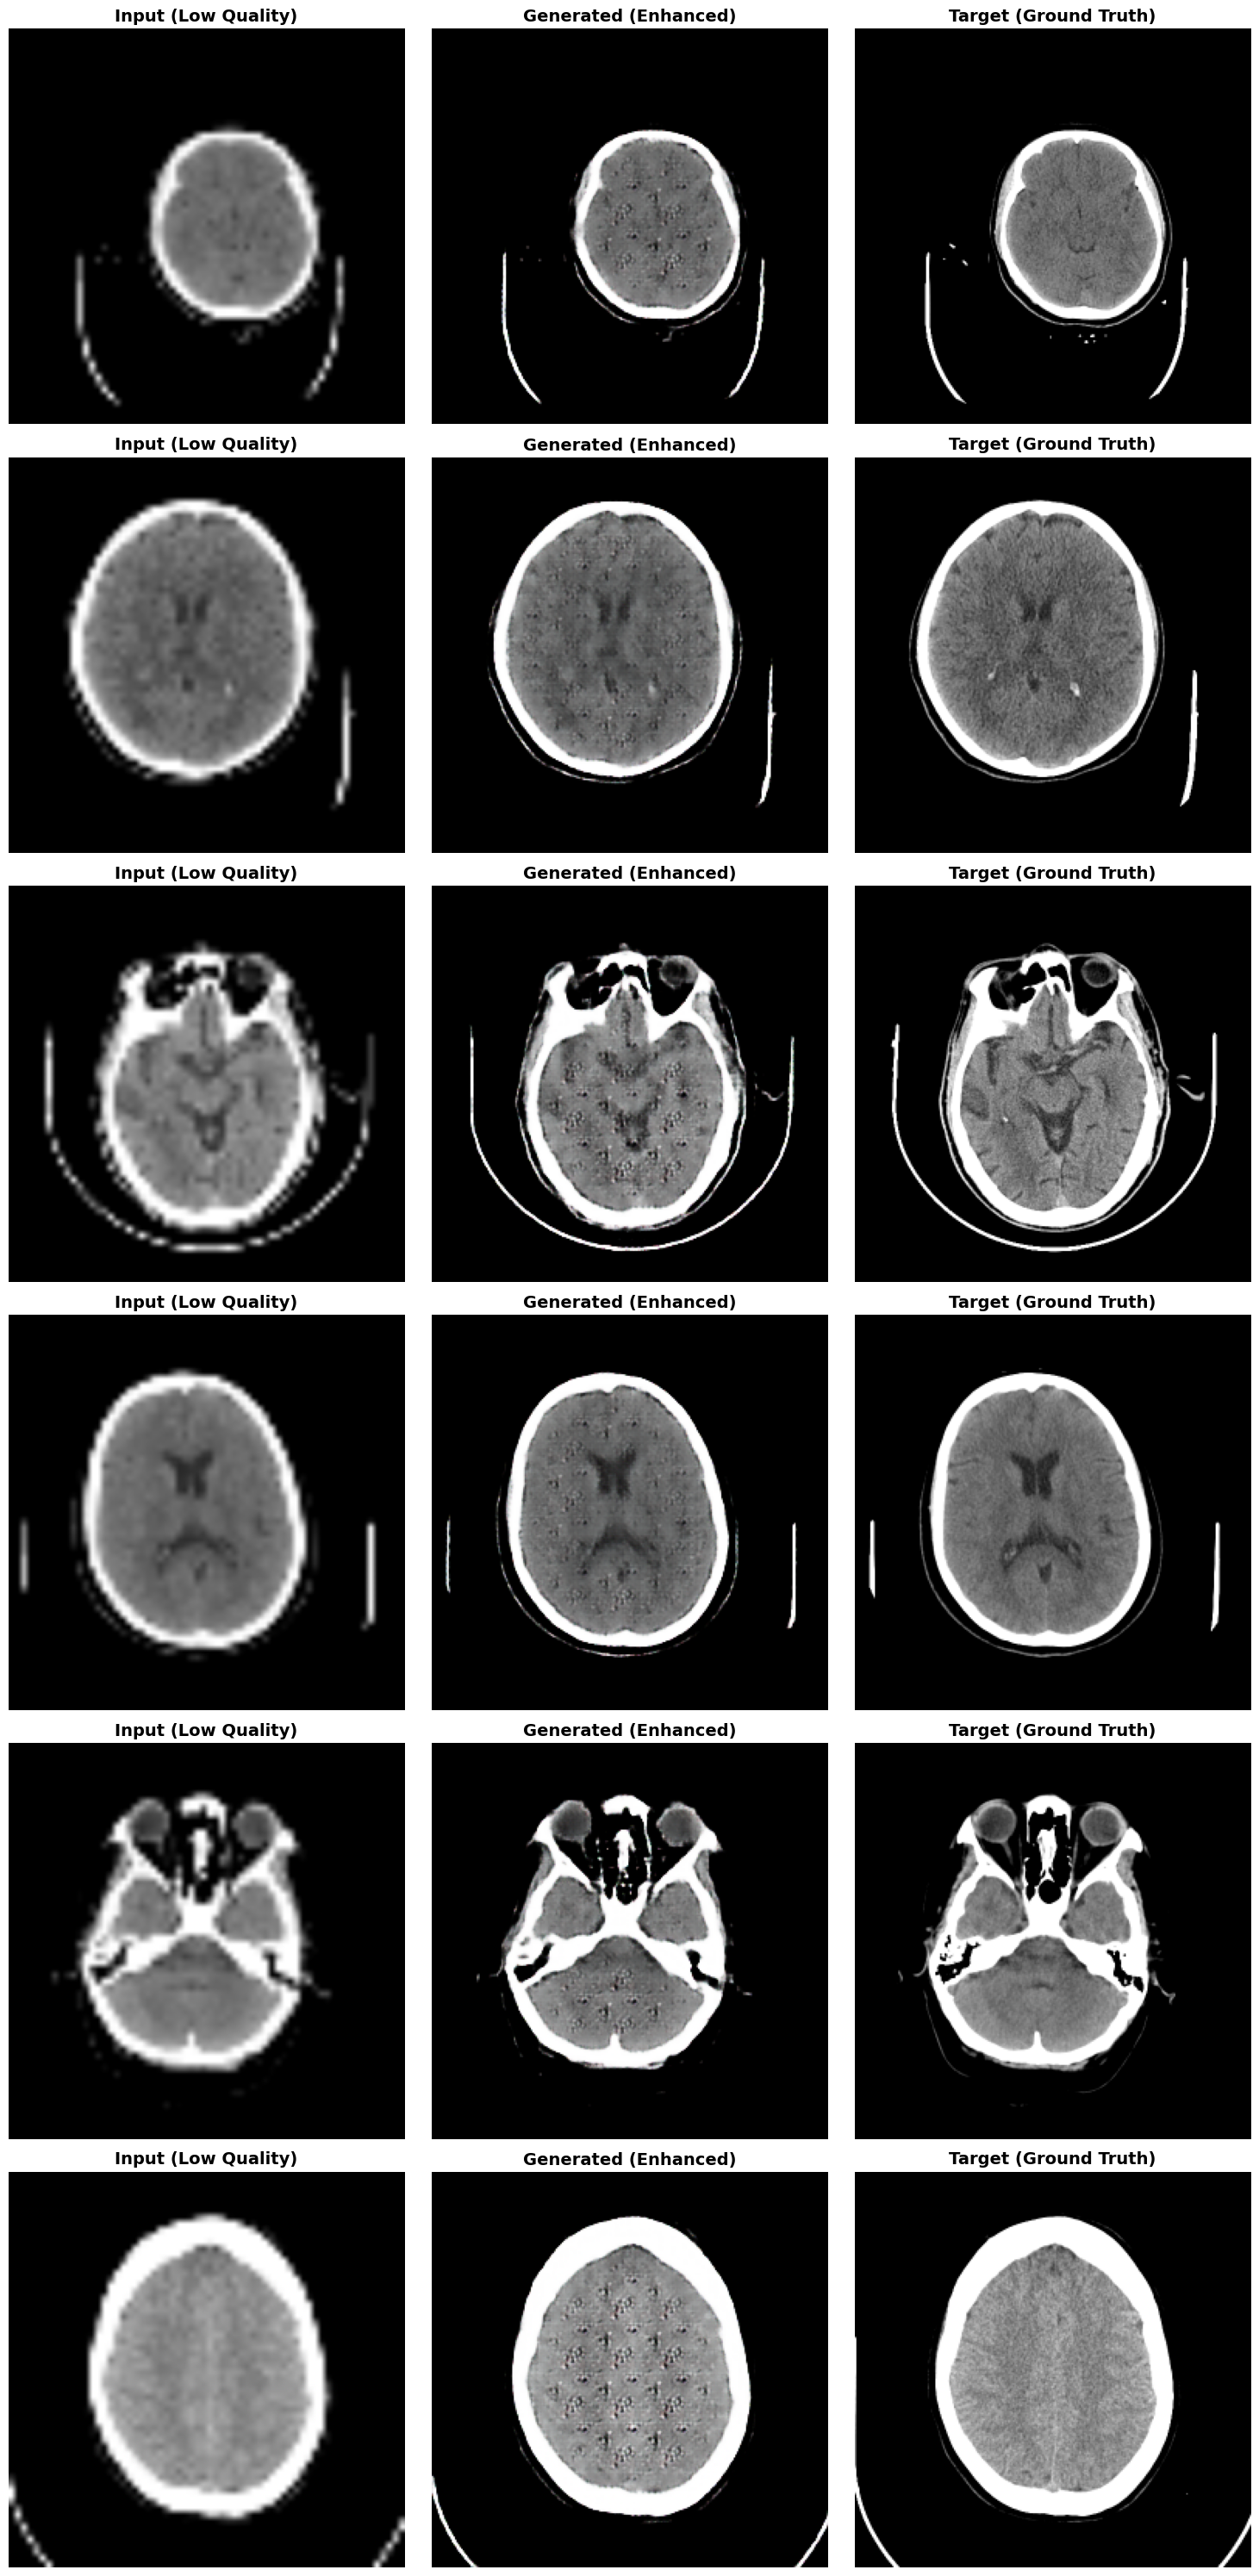


📊 Quality Metrics:
   MSE:  0.020824
   PSNR: 22.83 dB


In [21]:
print("\n" + "="*80)
print("LOAD CHECKPOINT & VISUALIZE PIX2PIX RESULTS")
print("="*80)

# Check if checkpoint exists
if checkpoint_manager.latest_checkpoint:
    print(f" Found checkpoint: {checkpoint_manager.latest_checkpoint}")
    checkpoint.restore(checkpoint_manager.latest_checkpoint)
    print(" Checkpoint restored successfully!")
else:
    print(" No checkpoint found.")

def visualize_pix2pix_results(inputs, targets, num_samples=3):
    """Visualize Pix2Pix generation results"""
    predictions = generator(inputs[:num_samples], training=False)

    # Convert predictions to numpy if it's a tensor
    if isinstance(predictions, tf.Tensor):
        predictions = predictions.numpy()

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        # Denormalize images (handle both numpy arrays and tensors)
        if isinstance(inputs, tf.Tensor):
            input_img = ((inputs[i].numpy() + 1) * 127.5).astype(np.uint8)
        else:
            input_img = ((inputs[i] + 1) * 127.5).astype(np.uint8)

        if isinstance(targets, tf.Tensor):
            target_img = ((targets[i].numpy() + 1) * 127.5).astype(np.uint8)
        else:
            target_img = ((targets[i] + 1) * 127.5).astype(np.uint8)

        pred_img = ((predictions[i] + 1) * 127.5).astype(np.uint8)

        # Clip values to valid range
        input_img = np.clip(input_img, 0, 255)
        target_img = np.clip(target_img, 0, 255)
        pred_img = np.clip(pred_img, 0, 255)

        axes[i, 0].imshow(input_img)
        axes[i, 0].set_title('Input (Low Quality)', fontsize=14, fontweight='bold')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(pred_img)
        axes[i, 1].set_title('Generated (Enhanced)', fontsize=14, fontweight='bold')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(target_img)
        axes[i, 2].set_title('Target (Ground Truth)', fontsize=14, fontweight='bold')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize results
if checkpoint_manager.latest_checkpoint:
    print("\n Generating visualizations...")
    print(f"Showing {min(6, len(val_inputs))} samples")
    visualize_pix2pix_results(val_inputs, val_targets, num_samples=min(6, len(val_inputs)))

    # Calculate and display some metrics
    print("\n Quality Metrics:")
    sample_preds = generator(val_inputs[:10], training=False).numpy()
    sample_targets = val_targets[:10]

    # Calculate MSE and PSNR
    mse = np.mean((sample_preds - sample_targets) ** 2)
    psnr = 10 * np.log10(4.0 / mse)  # 4.0 because images are in [-1, 1] range

    print(f"   MSE:  {mse:.6f}")
    print(f"   PSNR: {psnr:.2f} dB")
else:
    print("\n Train the model first to see visualizations!")

print("="*80)

In [22]:
def create_segmentation_model(num_classes=3):
    """Create segmentation model using transfer learning with MobileNetV2"""
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # Freeze base model
    base_model.trainable = False

    # Build model
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Preprocessing
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    return model, base_model

segmentation_model, base_model = create_segmentation_model()
segmentation_model.summary()

/tmp/ipython-input-2136100170.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,045,955 (11.62 MB)

 Trainable params: 787,971 (3.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# Compile model
segmentation_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

# Train stage 1 (frozen base)
print("\n=== Stage 1: Training with frozen base model ===")
history_stage1 = segmentation_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr]
)

Train: 5678, Val: 1420, Test: 1775

=== Stage 1: Training with frozen base model ===
Epoch 1/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 61s 112ms/step - accuracy: 0.6100 - loss: 0.9090 - val_accuracy: 0.7838 - val_loss: 0.5710 - learning_rate: 0.0010
Epoch 2/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.7591 - loss: 0.6028 - val_accuracy: 0.7676 - val_loss: 0.5759 - learning_rate: 0.0010
Epoch 3/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.7810 - loss: 0.5247 - val_accuracy: 0.8106 - val_loss: 0.4897 - learning_rate: 0.0010
Epoch 4/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8130 - loss: 0.4695 - val_accuracy: 0.8324 - val_loss: 0.4467 - learning_rate: 0.0010
Epoch 5/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.8339 - loss: 0.4350 - val_accuracy: 0.8049 - val_loss: 0.4879 - learning_rate: 0.0010
Epoch 6/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8370 - loss: 0.4170 - val_accuracy: 0.8155 - val_loss: 0.4433 - learning_rate: 0

In [24]:
base_model.trainable = True

# Freeze early layers
for layer in base_model.layers[:100]:
    layer.trainable = False

print(f"Trainable layers: {len([l for l in segmentation_model.layers if l.trainable])}")

# Recompile with lower learning rate
segmentation_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train stage 2 (fine-tuning)
print("\n=== Stage 2: Fine-tuning ===")
history_stage2 = segmentation_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr]
)

Trainable layers: 8

=== Stage 2: Fine-tuning ===
Epoch 1/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 61s 102ms/step - accuracy: 0.6853 - loss: 2.0576 - val_accuracy: 0.8261 - val_loss: 0.5473 - learning_rate: 1.0000e-05
Epoch 2/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.8274 - loss: 0.6130 - val_accuracy: 0.8430 - val_loss: 0.5145 - learning_rate: 1.0000e-05
Epoch 3/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.8740 - loss: 0.3461 - val_accuracy: 0.8479 - val_loss: 0.4596 - learning_rate: 1.0000e-05
Epoch 4/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9159 - loss: 0.2173 - val_accuracy: 0.8585 - val_loss: 0.4342 - learning_rate: 1.0000e-05
Epoch 5/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9306 - loss: 0.1786 - val_accuracy: 0.8634 - val_loss: 0.4456 - learning_rate: 1.0000e-05
Epoch 6/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9484 - loss: 0.1267 - val_accuracy: 0.8711 - val_loss: 0.4649 - learning_rate: 1.0000e-05
E

In [25]:
test_loss, test_accuracy = segmentation_model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predictions
y_pred = segmentation_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
label_names = ['Normal', 'Bleeding', 'Ischemia']
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 246ms/step - accuracy: 0.8791 - loss: 0.3609

Test Accuracy: 0.8817
Test Loss: 0.3684
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.91      0.93      0.92       886
    Bleeding       0.88      0.82      0.85       437
    Ischemia       0.83      0.85      0.84       452

    accuracy                           0.88      1775
   macro avg       0.87      0.87      0.87      1775
weighted avg       0.88      0.88      0.88      1775


Confusion Matrix:
[[825  19  42]
 [ 45 357  35]
 [ 40  29 383]]


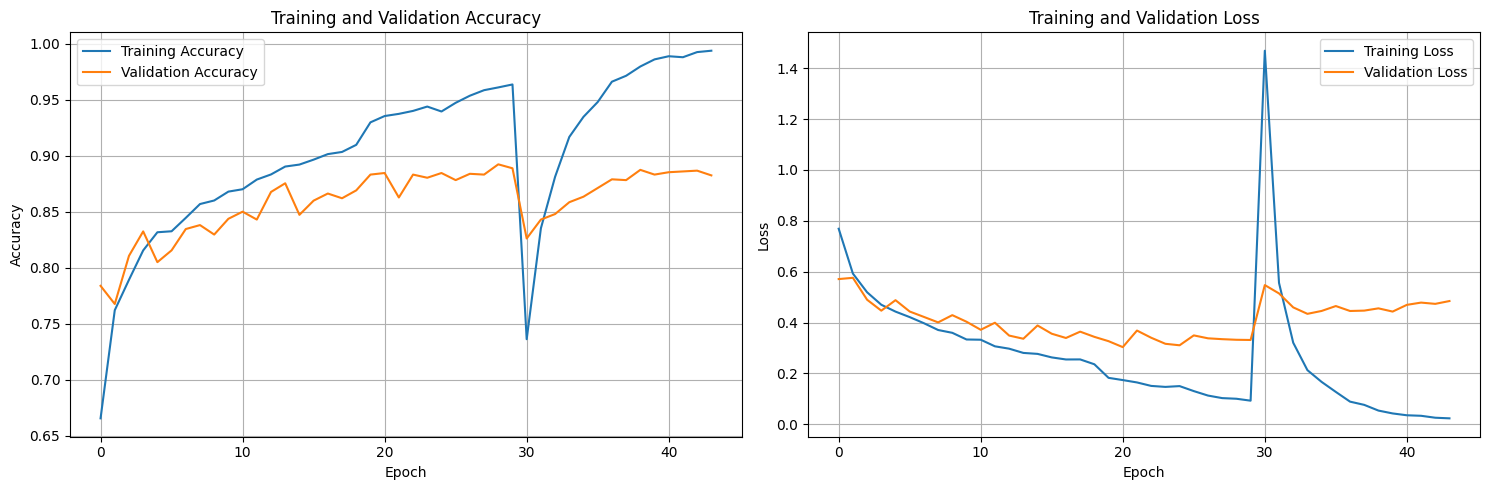

In [26]:
def plot_training_history(history1, history2=None):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Combine histories
    if history2:
        acc = history1.history['accuracy'] + history2.history['accuracy']
        val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
        loss = history1.history['loss'] + history2.history['loss']
        val_loss = history1.history['val_loss'] + history2.history['val_loss']
    else:
        acc = history1.history['accuracy']
        val_acc = history1.history['val_accuracy']
        loss = history1.history['loss']
        val_loss = history1.history['val_loss']

    epochs_range = range(len(acc))

    # Accuracy
    axes[0].plot(epochs_range, acc, label='Training Accuracy')
    axes[0].plot(epochs_range, val_acc, label='Validation Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Loss
    axes[1].plot(epochs_range, loss, label='Training Loss')
    axes[1].plot(epochs_range, val_loss, label='Validation Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history_stage1, history_stage2)

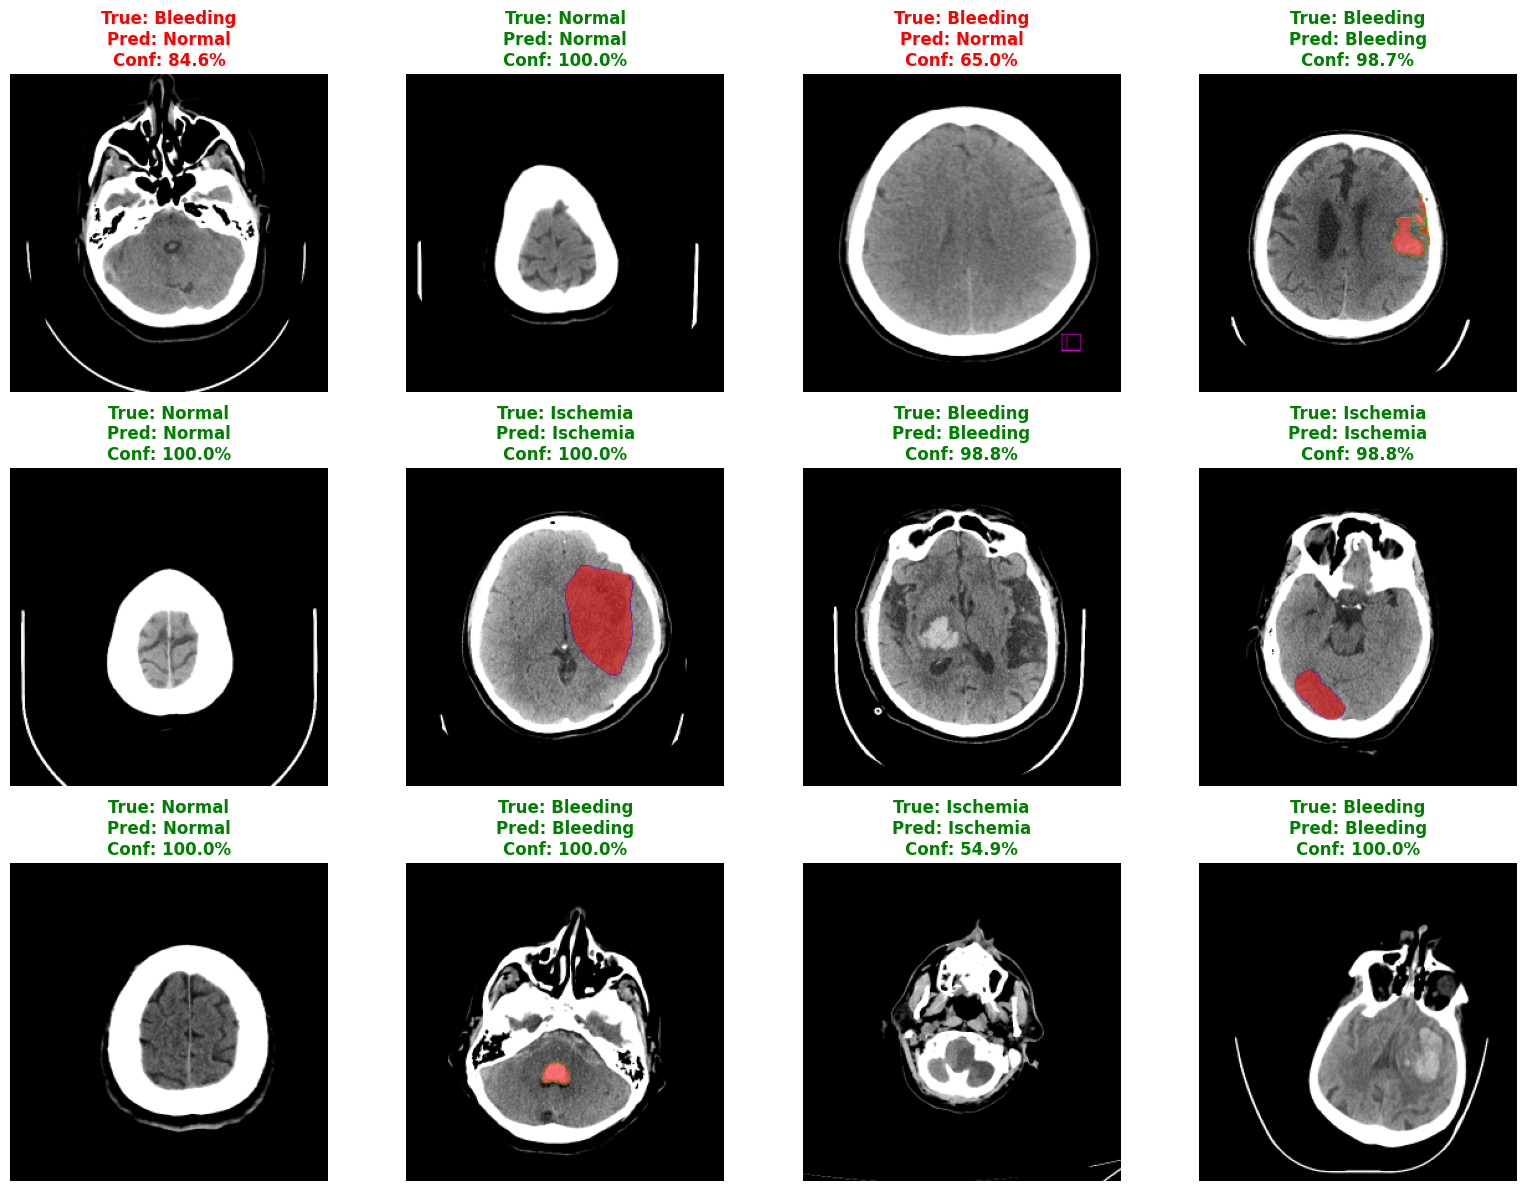

In [27]:
def visualize_predictions(images, true_labels, pred_labels, num_samples=12):
    """Visualize predictions with confidence scores"""
    label_names = ['Normal', 'Bleeding', 'Ischemia']

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()

    indices = random.sample(range(len(images)), min(num_samples, len(images)))

    for idx, img_idx in enumerate(indices):
        axes[idx].imshow(images[img_idx])

        true_label = label_names[true_labels[img_idx]]
        pred_label = label_names[pred_labels[img_idx]]
        confidence = np.max(y_pred[img_idx]) * 100

        color = 'green' if true_label == pred_label else 'red'
        title = f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%"

        axes[idx].set_title(title, color=color, fontweight='bold')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(X_test, y_test, y_pred_classes)

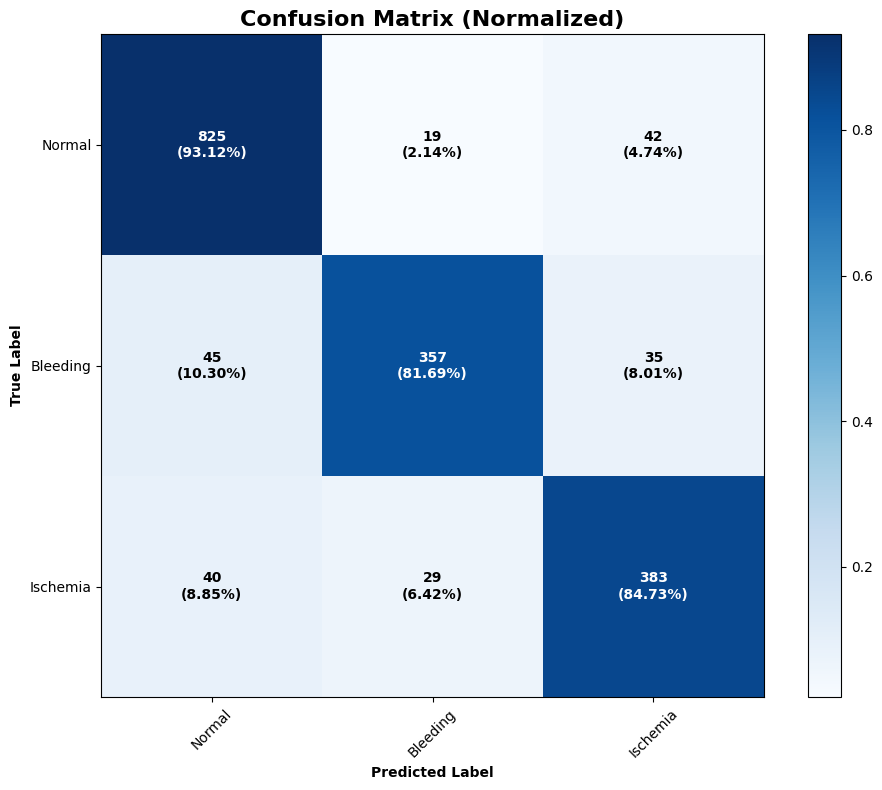

In [28]:
def plot_confusion_matrix(cm, labels):
    """Plot confusion matrix as heatmap"""
    plt.figure(figsize=(10, 8))

    # Normalize
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm_norm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix (Normalized)', fontsize=16, fontweight='bold')
    plt.colorbar()

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    # Add text annotations
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            plt.text(j, i, f'{cm[i, j]}\n({cm_norm[i, j]:.2%})',
                    ha="center", va="center",
                    color="white" if cm_norm[i, j] > thresh else "black",
                    fontweight='bold')

    plt.ylabel('True Label', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, label_names)

In [29]:
segmentation_model.save('pix2ct.h5')
print("Segmentation model saved as 'pix2ct.h5'")

Segmentation model saved as 'brain_stroke_segmentation_model.h5'
